<a href="https://colab.research.google.com/github/Zhagaran247/Analysis-on-Different-Activation-Function-CNN-/blob/main/Different_Activation_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PreLoading the data from Kaggle**

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cat-breeds-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F433636%2F840302%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240707%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240707T055950Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6553aab794c1926a40e1409de7bab44861ee5b76fc42fc4c7b57b2adb6fb36e96c3f283bfb126cae730cb2586a09f4ff2bab8fc3ef04e0ec0f5632b30b3966dcf3c0cc5a0634f7e6d7385225ec3b954e1ce8935063263c7eec8b995f51c0ccee2eb3ad734c5bd215e7969cd544575812254b8a239a47942c25d53bd30439d1065dfdd48373324d1d6fed3304e0b0e93392af049f840b2261a592932090fcb146773232312871f827d5c66cb1b1e579237c400a70732dcb6d03b8c0244d6046590242f0cb31de86db7ad98dfa2e397b73bd74484fd4013c6a6d3c999d8f2aa8ced9a621a0f2022cd7ba4e953759fe5eb2d253d19dc6abf3044586666131135c42'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2069609007 bytes downloaded
Downloaded and uncompressed: cat-breeds-dataset
Data source import complete.


# Importing modules and dataframe the input


In [ ]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from scipy import ndimage, misc
import skimage
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D


In [ ]:
!pip install livelossplot

In [ ]:
from livelossplot import PlotLossesKeras

In [ ]:
filelist  = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        filelist.append (os.path.join(dirname, filename))



In [ ]:
len(filelist)

126608

In [ ]:
filelist

['/kaggle/input/cat-breeds-dataset/data/cats.csv',
 '/kaggle/input/cat-breeds-dataset/images/Bombay/35639338_3856.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Bombay/45606480_594.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Bombay/43600437_1522.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Bombay/41497897_2271.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Bombay/25373625_6792.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Bombay/33397991_4554.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Bombay/44447685_1188.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Bombay/41391612_2306.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Bombay/41192156_2376.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Bombay/30984800_5200.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Bombay/33817249_4412.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Bombay/34732270_4133.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Bombay/41682173_2209.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Bombay/3615

In [ ]:
labels_needed = ['Abyssinian','Balinese','Tonkinese']

In [ ]:
Filepaths   = []
labels = []

for image_file in filelist:
    label = image_file.split(os.path.sep)[-2]
    if label in labels_needed:

        Filepaths.append(image_file)
        labels.append(label)



In [ ]:
set(labels)

{'Abyssinian', 'Balinese', 'Tonkinese'}

In [ ]:
len(Filepaths), len(labels)

(769, 769)

In [ ]:
df = pd.DataFrame( list( zip (Filepaths, labels) ), columns = ['Filepath', 'Labels'] )
df

,Filepath,Labels
0,/kaggle/input/cat-breeds-dataset/images/Tonkin...,Tonkinese
1,/kaggle/input/cat-breeds-dataset/images/Tonkin...,Tonkinese
2,/kaggle/input/cat-breeds-dataset/images/Tonkin...,Tonkinese
3,/kaggle/input/cat-breeds-dataset/images/Tonkin...,Tonkinese
4,/kaggle/input/cat-breeds-dataset/images/Tonkin...,Tonkinese
...,...,...
764,/kaggle/input/cat-breeds-dataset/images/Abyssi...,Abyssinian
765,/kaggle/input/cat-breeds-dataset/images/Abyssi...,Abyssinian
766,/kaggle/input/cat-breeds-dataset/images/Abyssi...,Abyssinian
767,/kaggle/input/cat-breeds-dataset/images/Abyssi...,Abyssinian


In [ ]:
from sklearn.utils import shuffle
df = (df.sample(frac = 1).reset_index()).drop(columns = 'index')
df


,Filepath,Labels
0,/kaggle/input/cat-breeds-dataset/images/Abyssi...,Abyssinian
1,/kaggle/input/cat-breeds-dataset/images/Abyssi...,Abyssinian
2,/kaggle/input/cat-breeds-dataset/images/Tonkin...,Tonkinese
3,/kaggle/input/cat-breeds-dataset/images/Tonkin...,Tonkinese
4,/kaggle/input/cat-breeds-dataset/images/Tonkin...,Tonkinese
...,...,...
764,/kaggle/input/cat-breeds-dataset/images/Baline...,Balinese
765,/kaggle/input/cat-breeds-dataset/images/Tonkin...,Tonkinese
766,/kaggle/input/cat-breeds-dataset/images/Tonkin...,Tonkinese
767,/kaggle/input/cat-breeds-dataset/images/Abyssi...,Abyssinian


### Displaying first 12 pictures

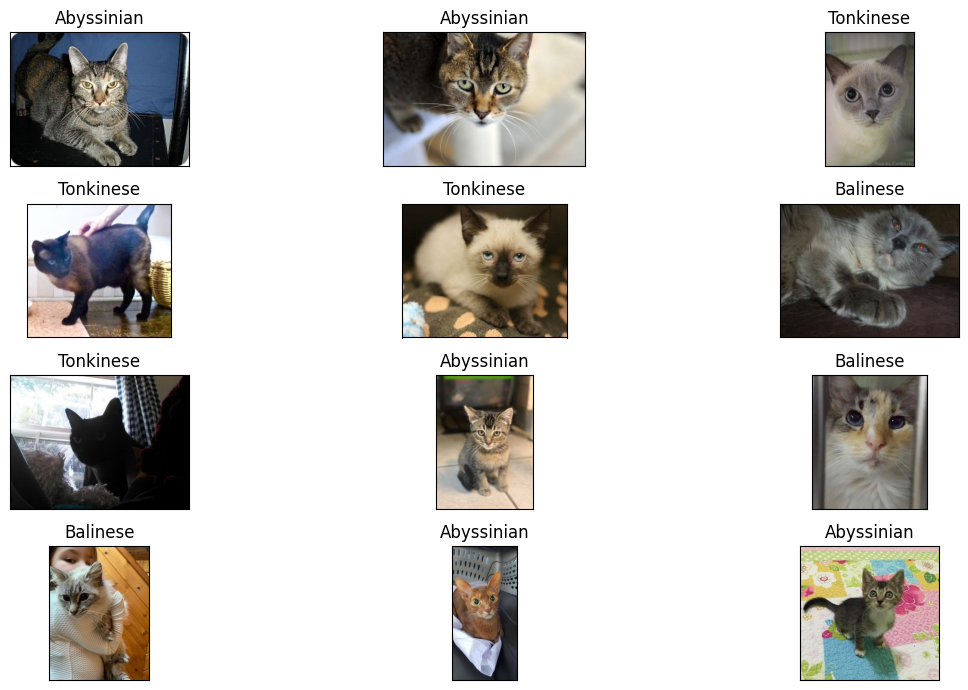

In [ ]:
f,a = plt.subplots(nrows=4, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Labels[i])

plt.tight_layout()
plt.show()

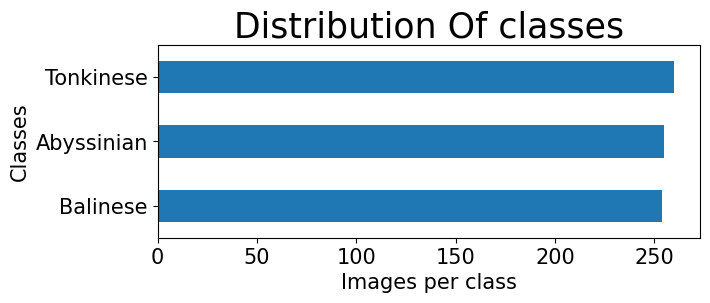

In [ ]:
ax=pd.value_counts(df['Labels'],ascending=True).plot(kind='barh',
                                                       fontsize="15",
                                                       title="Distribution Of classes",
                                                       figsize=(7,2.5))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.title.set_size(25)
plt.show()

In [ ]:
df.Labels.value_counts()

Labels
Tonkinese     260
Abyssinian    255
Balinese      254
Name: count, dtype: int64

### Splitting the data And Creating data generator

In [ ]:
train_ratio = .75
validation_ratio = 0.10
test_ratio = 0.25

train, test = train_test_split(df, test_size = test_ratio )
val, test = train_test_split(test, test_size=test_ratio/(test_ratio + validation_ratio))

In [ ]:
img_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip = 'true')


x_train =  img_datagen.flow_from_dataframe(dataframe = train,  x_col='Filepath', y_col='Labels',  target_size=(299, 299), shuffle=False, batch_size=30, seed = 12)
x_val = img_datagen.flow_from_dataframe(dataframe = val,  x_col='Filepath', y_col='Labels',  target_size=(299, 299), shuffle=False, batch_size=30, seed = 12)
x_test = img_datagen.flow_from_dataframe(dataframe = test,  x_col='Filepath', y_col='Labels',  target_size=(299, 299), shuffle=False, batch_size=30, seed = 12)

Found 576 validated image filenames belonging to 3 classes.
Found 55 validated image filenames belonging to 3 classes.
Found 138 validated image filenames belonging to 3 classes.


In [ ]:
x_train

# **No top Activation Function**

In [ ]:
i_model = InceptionV3(weights= 'imagenet', include_top=False, input_shape=(299, 299, 3))

In [ ]:
for layer in i_model.layers:
    layer.trainable = False

i_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 149, 149, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 149, 149, 32)         0         ['batch_normalizati

In [ ]:
model = Sequential()
model.add(i_model)
model.add(GlobalAveragePooling2D())

model.add(Dense(32))
model.add(Dropout(0.20))
model.add(Dense(3, activation = 'softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 32)                65568     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 21868451 (83.42 MB)
Trainable params: 65667 (256.51 KB)
Non-trainable params: 21802784 (83.17 MB)
________

In [ ]:
model.compile(optimizer = SGD(),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [ ]:
len(x_train)

20

In [ ]:
len(x_test)

5

In [ ]:
len(x_val)

2

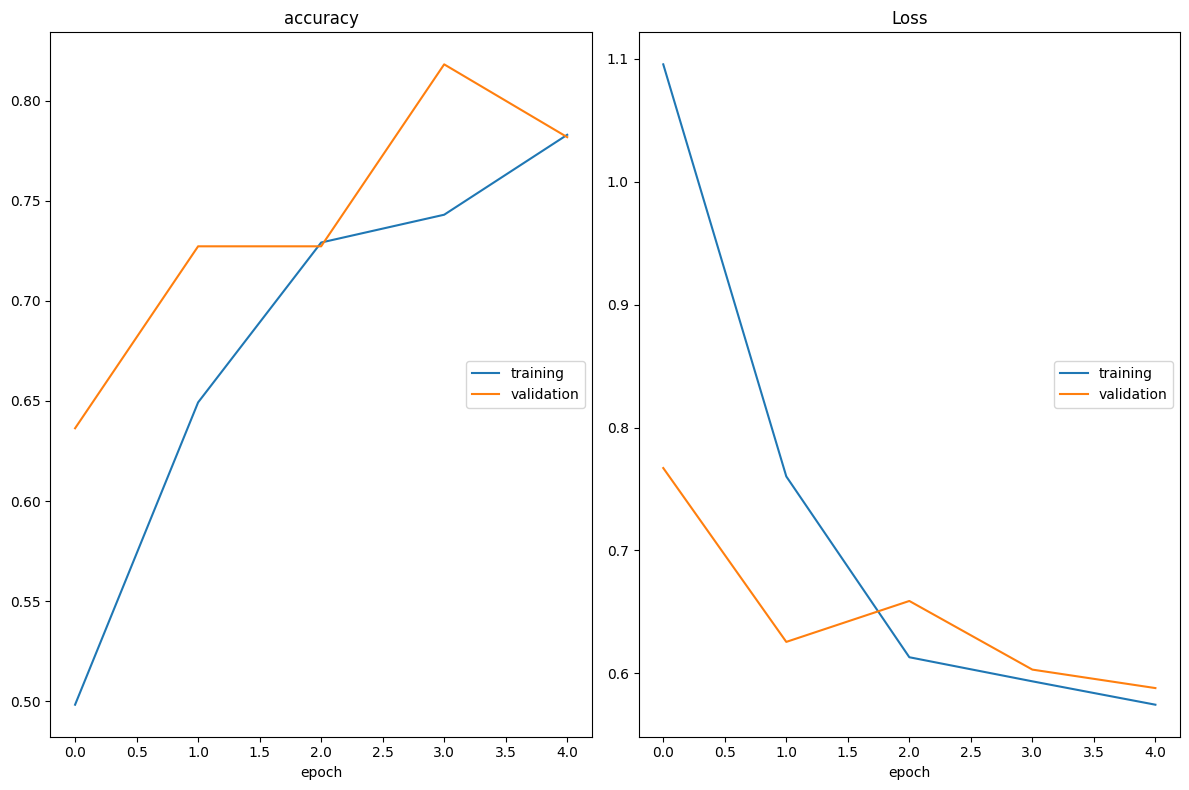

accuracy
	training         	 (min:    0.498, max:    0.783, cur:    0.783)
	validation       	 (min:    0.636, max:    0.818, cur:    0.782)
Loss
	training         	 (min:    0.574, max:    1.096, cur:    0.574)
	validation       	 (min:    0.588, max:    0.767, cur:    0.588)


In [ ]:
history = model.fit(x_train, validation_data = x_val,
                    steps_per_epoch = len(x_train),
                    validation_steps = len(x_val),
                    epochs = 5,
                    verbose = 0,callbacks=[PlotLossesKeras()])

In [ ]:
#prediction
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
predictions

5/5 [==============================] - 5s 670ms/step


array([1, 2, 0, 1, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 1, 0, 0, 2, 0, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 0, 1, 2, 1, 0, 0, 1, 1, 0, 2,
       0, 0, 0, 2, 1, 1, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 0,
       1, 0, 2, 2, 1, 0, 0, 0, 2, 0, 2, 1, 1, 1, 1, 0, 2, 1, 0, 0, 0, 0,
       2, 0, 1, 1, 0, 2, 1, 2, 1, 0, 2, 1, 1, 0, 1, 2, 0, 0, 2, 2, 0, 1,
       0, 2, 2, 0, 2, 0, 1, 1, 2, 0, 1, 1, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0,
       1, 2, 0, 1, 0, 2])

In [ ]:
labels = x_train.class_indices
labels

{'Abyssinian': 0, 'Balinese': 1, 'Tonkinese': 2}

In [ ]:
test["Labels"].replace({"Abyssinian": 0,'Balinese': 1,'Tonkinese': 2 }, inplace = True)


In [ ]:
#Accuracy
test_accuracy = model.evaluate(x_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

5/5 [==============================] - 4s 666ms/step - loss: 0.5555 - accuracy: 0.8188
Test accuracy is :  81.88405632972717 %


In [ ]:
#confusion matrix
cf = confusion_matrix(test.Labels , predictions)
cf

array([[42,  0,  5],
       [ 3, 31, 10],
       [ 2,  7, 38]])

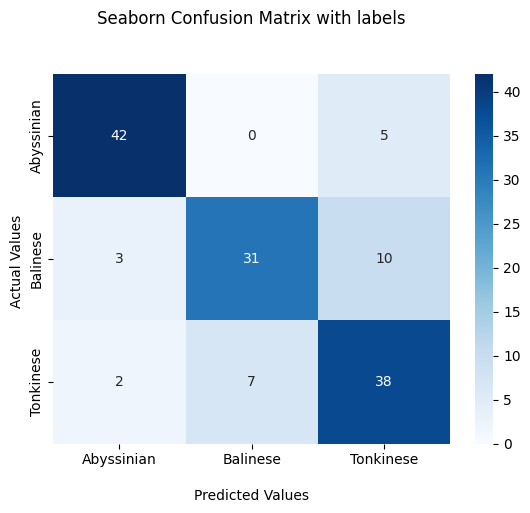

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Abyssinian','Balinese','Tonkinese'])
ax.yaxis.set_ticklabels(['Abyssinian','Balinese','Tonkinese'])


## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
print('F1 score is',f1_score(test.Labels, predictions, average = 'weighted'))


F1 score is 0.8042629904559915


# **No top activation Function - Report**

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test.Labels, predictions))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        47
           1       0.82      0.70      0.76        44
           2       0.72      0.81      0.76        47

    accuracy                           0.80       138
   macro avg       0.81      0.80      0.80       138
weighted avg       0.81      0.80      0.80       138



# **Sigmoid**

In [ ]:
i_model2 = InceptionV3(weights= 'imagenet', include_top='sigmoid', input_shape=(299, 299, 3))

96112376/96112376 [==============================] - 0s 0us/step


In [ ]:
for layer in i_model2.layers:
    layer.trainable = False

i_model2.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 149, 149, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 149, 149, 32)         0         ['batch_normalizati

In [ ]:
model2 = Sequential()
model2.add(i_model2)
model2.add(Dense(32))
model2.add(Dropout(0.30))
model2.add(Dense(3, activation = 'softmax'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1000)              23851784  
                                                                 
 dense_4 (Dense)             (None, 32)                32032     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 23883915 (91.11 MB)
Trainable params: 32131 (125.51 KB)
Non-trainable params: 23851784 (90.99 MB)
_________________________________________________________________


In [ ]:
model2.compile(optimizer = SGD(),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [ ]:
print(len(x_train))
print(len(x_test))
print(len(x_val))

20
5
2


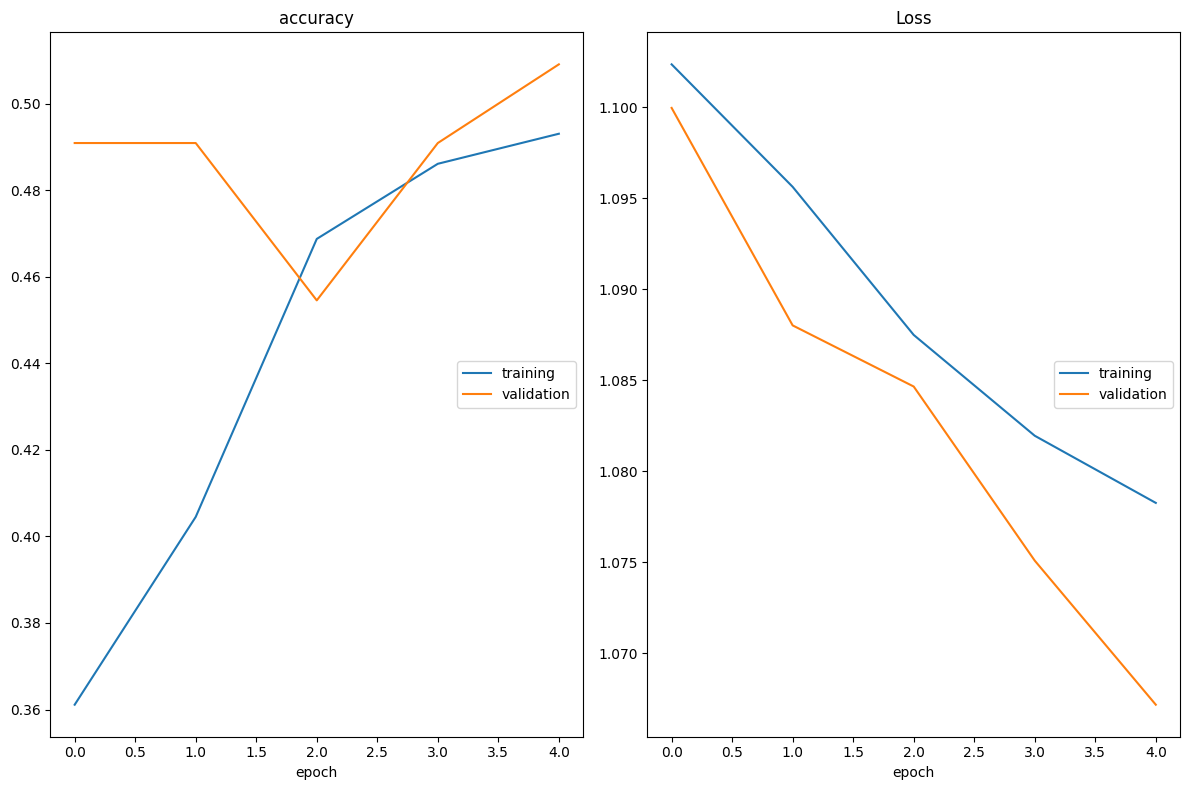

accuracy
	training         	 (min:    0.361, max:    0.493, cur:    0.493)
	validation       	 (min:    0.455, max:    0.509, cur:    0.509)
Loss
	training         	 (min:    1.078, max:    1.102, cur:    1.078)
	validation       	 (min:    1.067, max:    1.100, cur:    1.067)


In [ ]:
history2 = model2.fit(x_train, validation_data = x_val,
                    steps_per_epoch = len(x_train),
                    validation_steps = len(x_val),
                    epochs = 5,
                    verbose = 0,callbacks=[PlotLossesKeras()])

In [ ]:
predictions2 = model2.predict(x_test)
predictions2 = np.argmax(predictions2, axis=1)
predictions2

5/5 [==============================] - 5s 649ms/step


array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 2, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 2, 1, 1, 0, 0, 0, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 2, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 2, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1])

In [ ]:
labels2 = x_train.class_indices
labels2

{'Abyssinian': 0, 'Balinese': 1, 'Tonkinese': 2}

In [ ]:
test["Labels"].replace({"Abyssinian": 0,'Balinese': 1,'Tonkinese': 2 }, inplace = True)

In [ ]:
test_accuracy = model2.evaluate(x_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

5/5 [==============================] - 4s 672ms/step - loss: 1.0675 - accuracy: 0.5145
Test accuracy is :  51.44927501678467 %


In [ ]:
cf2 = confusion_matrix(test.Labels , predictions2)
cf2

array([[37,  9,  1],
       [ 5, 35,  4],
       [ 6, 40,  1]])

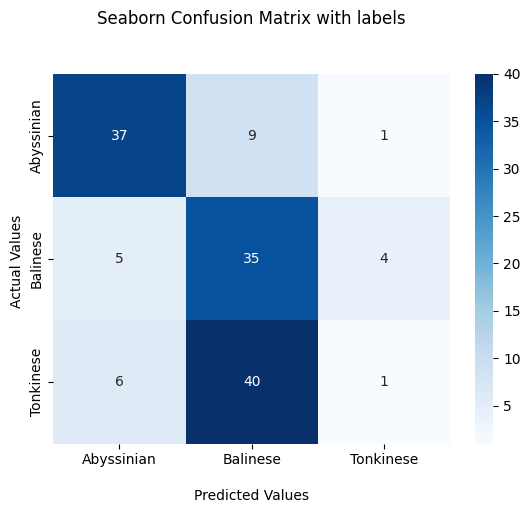

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf2, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['Abyssinian','Balinese','Tonkinese'])
ax.yaxis.set_ticklabels(['Abyssinian','Balinese','Tonkinese'])

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
print('F1 score is',f1_score(test.Labels, predictions2, average = 'weighted'))

F1 score is 0.4525116755177525


# **Sigmoid - Report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test.Labels, predictions2))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78        47
           1       0.42      0.80      0.55        44
           2       0.17      0.02      0.04        47

    accuracy                           0.53       138
   macro avg       0.45      0.53      0.45       138
weighted avg       0.45      0.53      0.45       138



# **TanH**

In [ ]:
i_model3 = InceptionV3(weights= 'imagenet', include_top='tanh', input_shape=(299, 299, 3))

In [ ]:
for layer in i_model3.layers:
    layer.trainable = False

i_model3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 149, 149, 32)         96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 149, 149, 32)         0         ['batch_normalizati

In [ ]:
model3 = Sequential()
model3.add(i_model3)
model3.add(Dense(32))
model3.add(Dropout(0.40))
model3.add(Dense(3, activation = 'softmax'))
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1000)              23851784  
                                                                 
 dense_6 (Dense)             (None, 32)                32032     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 3)                 99        
                                                                 
Total params: 23883915 (91.11 MB)
Trainable params: 32131 (125.51 KB)
Non-trainable params: 23851784 (90.99 MB)
_________________________________________________________________


In [ ]:
model3.compile(optimizer = SGD(),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [ ]:
print(len(x_train))
print(len(x_test))
print(len(x_val))

20
5
2


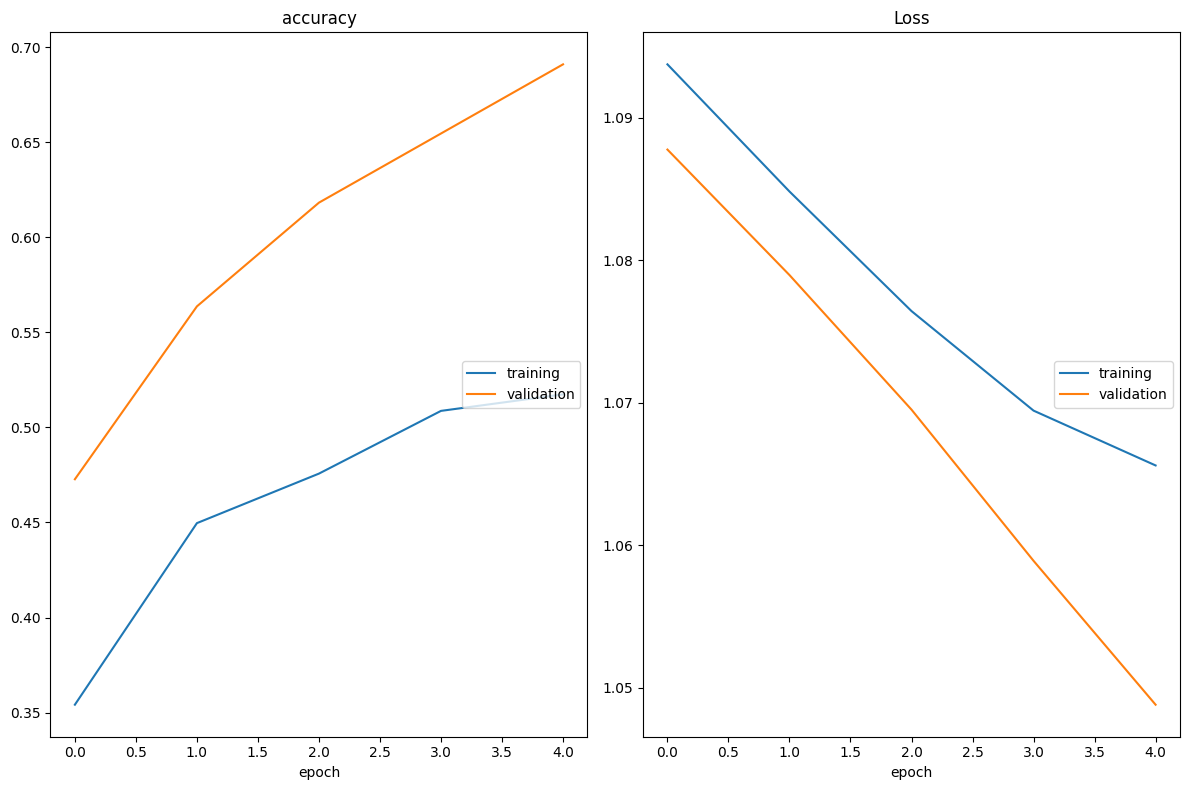

accuracy
	training         	 (min:    0.354, max:    0.517, cur:    0.517)
	validation       	 (min:    0.473, max:    0.691, cur:    0.691)
Loss
	training         	 (min:    1.066, max:    1.094, cur:    1.066)
	validation       	 (min:    1.049, max:    1.088, cur:    1.049)


In [ ]:
history3 = model3.fit(x_train, validation_data = x_val,
                    steps_per_epoch = len(x_train),
                    validation_steps = len(x_val),
                    epochs = 5,
                    verbose = 0,callbacks=[PlotLossesKeras()])

In [ ]:
predictions3 = model3.predict(x_test)
predictions3 = np.argmax(predictions3, axis=1)
predictions3

5/5 [==============================] - 5s 635ms/step


array([1, 1, 0, 1, 2, 2, 0, 2, 1, 2, 2, 0, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0,
       2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 1, 2, 0, 1,
       0, 0, 0, 2, 0, 2, 2, 1, 0, 2, 2, 2, 1, 2, 1, 2, 2, 0, 2, 0, 1, 0,
       2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 1, 2, 1, 2, 2, 0, 2, 2, 0, 2, 0, 0,
       2, 0, 2, 2, 1, 0, 2, 2, 2, 1, 1, 0, 2, 0, 2, 0, 1, 0, 2, 2, 0, 2,
       0, 1, 2, 0, 2, 0, 2, 2, 2, 0, 1, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2,
       2, 2, 0, 0, 0, 2])

In [ ]:
test_accuracy = model3.evaluate(x_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

5/5 [==============================] - 4s 669ms/step - loss: 1.0485 - accuracy: 0.6232
Test accuracy is :  62.31883764266968 %


In [ ]:
cf3 = confusion_matrix(test.Labels , predictions3)
cf3

array([[39,  4,  4],
       [ 6,  6, 32],
       [ 4, 10, 33]])

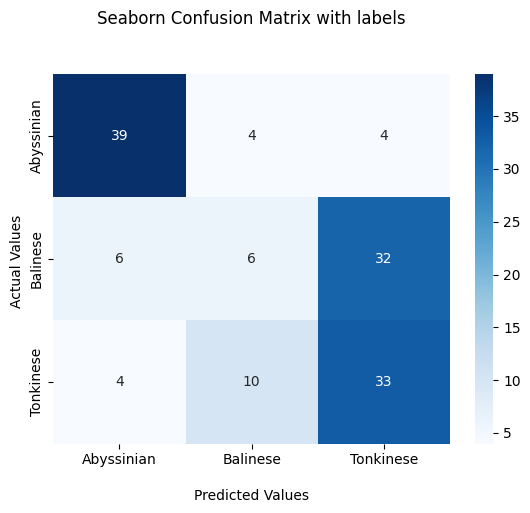

In [ ]:
#confusion matrix
ax = sns.heatmap(cf3, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['Abyssinian','Balinese','Tonkinese'])
ax.yaxis.set_ticklabels(['Abyssinian','Balinese','Tonkinese'])

plt.show()

In [ ]:

print('F1 score is',f1_score(test.Labels, predictions3, average = 'weighted'))

F1 score is 0.5302817341329336


# **Report - TanH**

In [ ]:
print(classification_report(test.Labels, predictions3))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81        47
           1       0.30      0.14      0.19        44
           2       0.48      0.70      0.57        47

    accuracy                           0.57       138
   macro avg       0.52      0.56      0.52       138
weighted avg       0.53      0.57      0.53       138

